# Issue with contiguity masking Sentinel-2 at 10m resolution

## Sample query

In [1]:
import odc.algo
import datacube 
import xarray as xr
import matplotlib.pyplot as plt

dc = datacube.Datacube()

# Jervis Bay
ymax, xmin = -35.089990, 150.681434
ymin, xmax = -35.141944, 150.734306

# # Roebuck
# ymax, xmin = -28.086443, 153.445244
# ymin, xmax = -28.274374, 153.598194

query = {
    'x': (xmin, xmax),
    'y': (ymax, ymin),
    'time': ('2018-01', '2018-1'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'fmask'],
    'output_crs': 'EPSG:32756',
    'group_by': 'solar_day'
}


## Load and preview data at 20m resolution

In [2]:
# Load data
ds = dc.load(product='s2b_ard_granule', 
             resolution=(-200, 200),
             **query)

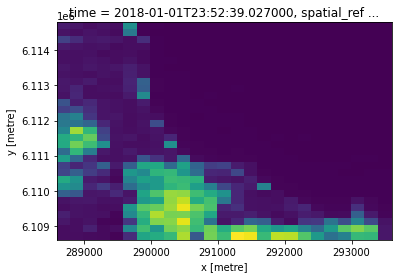

In [7]:
ds.nbart_red.isel(time=0).plot(add_colorbar=False)

In [21]:
from datacube.utils.cog import write_cog
write_cog(ds.isel(time=1).nbart_red, fname='raster.tif', overwrite=True)

PosixPath('raster.tif')

In [30]:
from datacube.testutils.io import rio_slurp_xarray
raster = rio_slurp_xarray("raster.tif", gbox=ds.geobox, resampling='average')

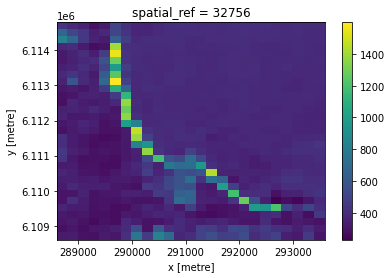

In [31]:
out.plot()

In [32]:
# Load raster
raster = xr.open_rasterio("raster.tif").squeeze("band")

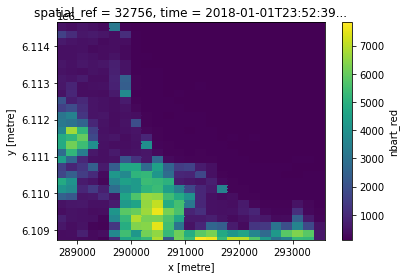

In [38]:
import odc.algo
odc.algo.xr_reproject(ds, raster.geobox, resampling='nearest').nbart_red.isel(time=0).plot()

## Create basic fmask mask

In [ ]:
# ds.fmask.plot(col='time', col_wrap=4)

In [ ]:
mask = odc.algo.fmask_to_bool(ds.fmask, categories=['valid', 'snow', 'water'])

In [ ]:
# mask.plot(col='time', col_wrap=4)

## Create cleaned and buffered mask

In [ ]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, disk

# def cloud_buffer(da, radius=0, base_radius=10):

#     # First remove small or narrow features using morphological closing
#     mask_closing = binary_closing(da, disk(base_radius))
    
#     # Then buffer remaining pixels by a radius to mask cloud edges
#     mask_buffer = binary_erosion(mask_closing, disk(radius))
    
#     return mask_buffer

def cloud_buffer(da, radius=5, base_radius=10):

    # First remove small or narrow features using morphological closing
    mask_closing = binary_dilation(da, disk(base_radius))
    
    # Then buffer remaining pixels by a radius to mask cloud edges
    mask_buffer = binary_erosion(mask_closing, disk(radius))
    
    return mask_buffer

new_mask = mask.groupby('time').apply(cloud_buffer)

In [ ]:
ds.where(mask)[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().isel(time=slice(8, 16)).plot.imshow(robust=True, col='time', col_wrap=4)
ds.where(new_mask)[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().isel(time=slice(8, 16)).plot.imshow(robust=True, col='time', col_wrap=4)

# rgb_mask = ds.where(mask)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
# rgb_new_mask = .median(dim='time')

In [ ]:
cloudy_scenes = ds.where(new_mask).nbart_blue.mean(dim=['x', 'y']) < 3000
# ds.where(new_mask).sel(time=cloudy_scenes)[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().isel(time=slice(8, 16)).plot.imshow(robust=True, col='time', col_wrap=4)


In [ ]:
# Compute median RGB and sum of good data through time
rgb_mask = ds.where(mask).sel(time=cloudy_scenes)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
rgb_new_mask = ds.where(new_mask).sel(time=cloudy_scenes)[['nbart_red', 'nbart_green', 'nbart_blue']].median(dim='time')
sum_mask = mask.sel(time=cloudy_scenes).sum(dim='time')
sum_new_mask = new_mask.sel(time=cloudy_scenes).sum(dim='time')

In [ ]:
# Create four panel figure
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot median RGB composites into left column
rgb_mask.to_array().plot.imshow(robust=True, ax=axes[0, 0])
rgb_new_mask.to_array().plot.imshow(robust=True, ax=axes[1, 0])

# Calculate count stats and plot count arrays into right column
vmax = xr.concat([sum_mask.max(), sum_new_mask.max()], dim='time').max().item()
sum_mask.plot(vmin=0, vmax=vmax, ax=axes[0, 1])
sum_new_mask.plot(vmin=0, vmax=vmax, ax=axes[1, 1])

# Set titles
axes[0, 0].set_title("RGB; fmask")
axes[0, 1].set_title("Good data count; fmask")
axes[1, 0].set_title("RGB; fmask with filtering")
axes[1, 1].set_title("Good data count; fmask with filtering");

In [ ]:
from datacube.utils.cog import write_cog

# write_cog(rgb_new_mask.to_array(), fname='test2.tif')

In [ ]:
# raster = xr.open_rasterio('test2.tif')
# write_cog(raster.isel(band=0), fname='raster.tif')


In [3]:
import xarray as xr
import datacube

# Connect to datacube
dc = datacube.Datacube()

# Load raster
raster = xr.open_rasterio("raster.tif").squeeze("band")

# Load data from datacube. `like=raster.geobox` step will load data
# from the datacube using the same resolution and CRS of `raster`
ds = dc.load(
    product="s2b_ard_granule",
    measurements=["nbart_red"],
    time=("2018-01", "2018-02"),
    like=raster.geobox,
    resampling="nearest",
    group_by="solar_day",
)

# Use raster data as a mask
ds.where(raster > 500)

<xarray.Dataset>
Dimensions:      (time: 6, x: 756, y: 1045)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-02...
  * y            (y) float64 6.893e+06 6.893e+06 ... 6.872e+06 6.872e+06
  * x            (x) float64 5.437e+05 5.437e+05 ... 5.588e+05 5.588e+05
    spatial_ref  int32 32756
    band         int64 1
Data variables:
    nbart_red    (time, y, x) float64 1.8e+03 1.791e+03 1.954e+03 ... nan nan
Attributes:
    crs:           +init=epsg:32756
    grid_mapping:  spatial_ref

In [ ]:
ds